# Implementation of a Directional score (multi-class / multi-label)

# Comparison BASELINE / CRNN

Author : Antony Cellier : cellier@cerfacs.fr

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import helping_modules.pre_treatment as pt
import helping_modules.precision as pr

print('Done')

Using TensorFlow backend.


Done


In [2]:
import keras
keras.__version__
import tensorflow as tf
from keras import backend as K
from keras.backend.tensorflow_backend import set_session

# For GPU allocation 
# Comment when running on CPU
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

print('Done')

Done


In [3]:
from keras.utils import np_utils
from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

print('Done')

Done


# LOAD INPUTS / TARGETS

In [4]:
Inputs_train = np.load('../DATA/inputs_targets/INPUTS_TRAIN_STATS.npy')
Targets_train = np.load('../DATA/inputs_targets/TARGETS_TRAIN_STATS.npy')
Positions_train = np.load('inputs_targets/POSITIONS_TRAIN_STATS.npy')
Inputs_test = np.load('../DATA/inputs_targets/INPUTS_TEST_STATS.npy')
Targets_test = np.load('../DATA/inputs_targets/TARGETS_TEST_STATS.npy')
Positions_test = np.load('inputs_targets/POSITIONS_TEST_STATS.npy')
Inputs_valid = np.load('../DATA/inputs_targets/INPUTS_VALID_STATS.npy')
Targets_valid = np.load('../DATA/inputs_targets/TARGETS_VALID_STATS.npy')
Positions_valid = np.load('inputs_targets/POSITIONS_VALID_STATS.npy')

In [5]:
N_t = Inputs_train.shape[1]
N_channel = Inputs_train.shape[2]

print('Done')

Done


# LOAD A MODEL

Best loss at :  17 Epochs ( 0.3258483715557758 )
Best accuracy at :  17 Epochs ( 0.9056481476183291 )
Model loaded :  17 Epochs
Model specs : VAL LOSS :  0.3258483715557758 , VAL ACC :  0.9056481476183291


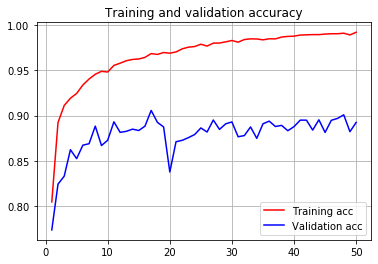

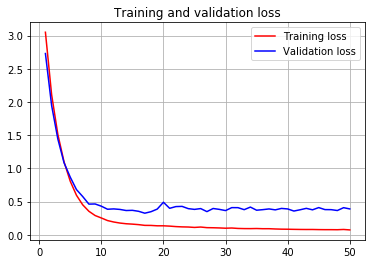

Done


In [6]:
# import a model to evaluate

N_f = 50
N_save = 1

Version = 'V4'
optim = 'loss'
Folder = 'CRNN_3chan'
Model = 'CRNN_3chan'

# load and plot its history

History_eval = np.load('saved_models_' + Folder + '/History_Save_' + Model + '_' + str(N_f) + 'ep_' + Version + '.npy')

acc = History_eval[0]
val_acc = History_eval[1]
loss = History_eval[2]
val_loss = History_eval[3]

N_lim = 100

Optim_loss = (np.argmin(val_loss[N_save-1:N_lim:N_save])+1)*N_save
Optim_acc = (np.argmax(val_acc[N_save-1:N_lim:N_save])+1)*N_save
print('Best loss at : ', Optim_loss, 'Epochs (', val_loss[Optim_loss-1], ')')
print('Best accuracy at : ', Optim_acc, 'Epochs (', val_acc[Optim_acc-1], ')')

if optim == 'loss':
    
    Ind = Optim_loss
    print('Model loaded : ', Ind, 'Epochs')
    print('Model specs : VAL LOSS : ', val_loss[Ind-1], ', VAL ACC : ', val_acc[Ind-1])

    model_eval = models.load_model('saved_models_' + Folder + '/' + Model + '_model_' + str(Ind) + 'ep_' + Version + '.h5')
    
else:
    
    Ind = Optim_acc
    print('Model loaded : ', Ind, 'Epochs')
    print('Model specs : VAL LOSS : ', val_loss[Ind-1], ', VAL ACC : ', val_acc[Ind-1])

    model_eval = models.load_model('saved_models_' + Folder + '/' + Model + '_model_' + str(Ind) + 'ep_' + Version + '.h5')


epochs = range(1,len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.grid(axis='both')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.grid(axis='both')
plt.legend()

plt.show()

print('Done')

# EVALUATE THE PERFORMANCES OF THE MODEL

In [7]:
# Evaluate the model on test data

batch_test = 256
test_loss, test_acc = model_eval.evaluate(Inputs_test, Targets_test, batch_size=batch_test)
print('test acc :', test_acc)
print('test loss :', test_loss)

8400/8400 [==============================] - 5s 549us/step
test acc : 0.8773214291390918
test loss : 0.39639404768035524


In [8]:
Y_V = model_eval.predict(Inputs_valid)
Y_T = model_eval.predict(Inputs_test)

In [9]:
print('Valid Loss : ', pr.Loss_Calc(Y_V, Targets_valid))
print('Valid BinC : ', pr.BinC_Calc(Y_V, Targets_valid))
print('Valid Acc : ', pr.Acc_Calc(np.floor(Y_V+0.5), Targets_valid))
print('Test Loss : ', pr.Loss_Calc(Y_T, Targets_test))
print('Test BinC : ', pr.BinC_Calc(Y_T, Targets_test))
print('Test Acc : ', pr.Acc_Calc(np.floor(Y_T+0.5), Targets_test))

Valid Loss :  0.27085479232630816
Valid BinC :  0.270854792247076
Valid Acc :  0.9056481481481482
Test Loss :  0.3414009573877632
Test BinC :  0.3414009574329831
Test Acc :  0.8773214285714286


# BUILD THE LOGISTIC REGRESSION

In [11]:
def norm_set(SET):
    
    SET_norm = np.zeros(SET.shape)
    
    SET_norm[:,0] = SET[:,0]/13
    SET_norm[:,1] = SET[:,1]/3
    
    return SET_norm

def LogReg_DIR(Inputs_train, Targets_train, Inputs_valid, Inputs_test, DIR):
    LR = LogisticRegression(tol=0.0001, C=1, max_iter=1000, multi_class='auto')
    
    Inputs_train_norm = norm_set(Inputs_train)
    LR.fit(Inputs_train_norm, Targets_train[:,DIR])
    
    Inputs_valid_norm = norm_set(Inputs_valid)    
    y_pred_valid = LR.predict_proba(Inputs_valid_norm)[:,1]
    
    Inputs_test_norm = norm_set(Inputs_test)
    y_pred_test = LR.predict_proba(Inputs_test_norm)[:,1]
    
    return LR, y_pred_valid, y_pred_test

y_pred_valid = np.zeros((Inputs_valid.shape[0],4))
y_pred_test = np.zeros((Inputs_test.shape[0],4))
y_pred_valid_ind = np.zeros((Inputs_valid.shape[0],4))
y_pred_test_ind = np.zeros((Inputs_test.shape[0],4))
LR = []

for k in range(4):
    LR_k, y_pred_valid_k, y_pred_test_k = LogReg_DIR(Positions_train, Targets_train, Positions_valid, Positions_test, k)

    LR += [LR_k]
    
    y_pred_valid[:,k] = y_pred_valid_k
    y_pred_test[:,k] = y_pred_test_k
    y_pred_valid_ind[:,k] = np.floor(y_pred_valid_k + 0.5)
    y_pred_test_ind[:,k] = np.floor(y_pred_test_k + 0.5)

print('Validation Accuracy', pr.Acc_Calc(y_pred_valid_ind, Targets_valid))
print('Testing Accuracy', pr.Acc_Calc(y_pred_test_ind, Targets_test))

print('Validation Loss', pr.Loss_Calc(y_pred_valid, Targets_valid))
print('Testing Loss', pr.Loss_Calc(y_pred_test, Targets_test))

Validation Accuracy 0.7777777777777778
Testing Accuracy 0.7678571428571429
Validation Loss 0.5028318938544751
Testing Loss 0.4996938032410918


# COMPARE ROC CURVES

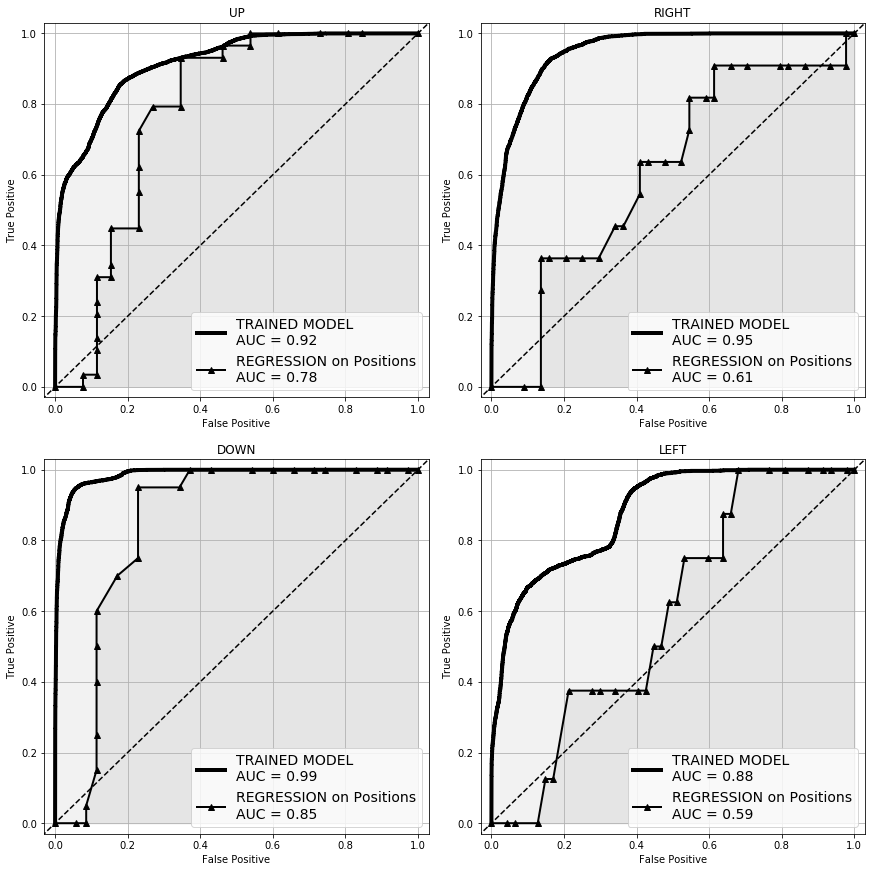

In [13]:
Legend = ['TRAINED MODEL', 'REGRESSION on Positions']

NT = Targets_valid.shape[0] + Targets_test.shape[0]

Targets = np.zeros((2, NT, 4))
Pred_proba = np.zeros((2, NT, 4))

Targets[0, :, :] = np.concatenate([Targets_valid, Targets_test])
Pred_proba[0, :, :] = np.concatenate([Y_V, Y_T])

Targets[1, :, :] = np.concatenate([Targets_valid, Targets_test])
Pred_proba[1, :, :] = np.concatenate([y_pred_valid, y_pred_test])

pr.ROC(Targets, Pred_proba, Legend)